In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import json
import math
import random
import re
import time
from collections import Counter
from typing import List, Tuple, Optional

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report

# 1. 设置随机种子
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# 2. 选择设备
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: mps (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device: cuda")
else:
    device = torch.device("cpu")
    print("Using device: cpu")

Using device: mps (Apple Silicon)


## 1. 数据处理 (Data Processing)
沿用之前的分词器和数据集逻辑，但为了适应更大的模型，我们可以稍微增加词表大小。

In [2]:
# 读取数据
data_path = "../DATA/dataset.json"
with open(data_path, "r", encoding="utf-8") as f:
    records = json.load(f)
print(f"Total samples: {len(records)}")

# --- Tokenizer ---
class WhitespaceTokenizer:
    def __init__(self, max_vocab_size: int = 50000, min_freq: int = 2, max_length: int = 128):
        self.max_vocab_size = max_vocab_size
        self.min_freq = min_freq
        self.max_length = max_length
        self.pad_token = "<pad>"
        self.unk_token = "<unk>"
        self.cls_token = "<cls>"
        self.token_to_id = {self.pad_token: 0, self.unk_token: 1, self.cls_token: 2}
        self.id_to_token = {0: self.pad_token, 1: self.unk_token, 2: self.cls_token}

    def tokenize(self, text: str) -> List[str]:
        text = str(text).lower().strip()
        return re.findall(r"\w+|[^\w\s]", text)

    def build_vocab(self, texts: List[str]) -> None:
        counter = Counter()
        for t in texts:
            counter.update(self.tokenize(t))
        most_common = [w for w, c in counter.most_common(self.max_vocab_size) if c >= self.min_freq]
        for idx, token in enumerate(most_common, start=len(self.token_to_id)):
            if token not in self.token_to_id:
                self.token_to_id[token] = idx
                self.id_to_token[idx] = token

    def encode(self, text: str) -> Tuple[List[int], List[int]]:
        tokens = [self.cls_token] + self.tokenize(text)
        tokens = tokens[: self.max_length]
        ids = [self.token_to_id.get(tok, self.token_to_id[self.unk_token]) for tok in tokens]
        pad_length = self.max_length - len(ids)
        if pad_length > 0:
            ids += [self.token_to_id[self.pad_token]] * pad_length
        attention_mask = [1 if i != self.token_to_id[self.pad_token] else 0 for i in ids]
        return ids, attention_mask

# --- Dataset ---
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.labels = torch.tensor(labels, dtype=torch.long)
        # Pre-tokenize all texts to save CPU time during training
        # 预分词：在初始化时处理所有文本，避免在训练循环中重复计算
        print("Pre-tokenizing dataset (this may take a moment)...")
        self.input_ids = []
        self.attention_masks = []
        
        for t in texts:
            ids, mask = tokenizer.encode(t)
            self.input_ids.append(ids)
            self.attention_masks.append(mask)
            
        self.input_ids = torch.tensor(self.input_ids, dtype=torch.long)
        self.attention_masks = torch.tensor(self.attention_masks, dtype=torch.long)
        print("Pre-tokenization complete.")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # 直接返回预处理好的 Tensor，速度更快
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx],
        }

def prepare_data(records, text_key, tokenizer):
    df = pd.DataFrame(records)
    texts = df[text_key].fillna("").tolist()
    labels_raw = df["category"].tolist()
    
    unique_labels = sorted(set(labels_raw))
    label2id = {label: i for i, label in enumerate(unique_labels)}
    id2label = {i: label for label, i in label2id.items()}
    labels = [label2id[l] for l in labels_raw]
    
    tokenizer.build_vocab(texts)
    dataset = NewsDataset(texts, labels, tokenizer)
    
    total = len(dataset)
    train_size = int(0.7 * total)
    val_size = int(0.15 * total)
    meta_size = total - train_size - val_size
    
    train_ds, val_ds, meta_ds = random_split(
        dataset, [train_size, val_size, meta_size], 
        generator=torch.Generator().manual_seed(42)
    )
    return train_ds, val_ds, meta_ds, label2id, id2label

Total samples: 209527


## 2. 高级模型架构 (Advanced Architecture)

### 核心组件：
1.  **RMSNorm**: 比 LayerNorm 更简单且效果相当或更好。
2.  **RoPE (Rotary Positional Embedding)**: 将绝对位置信息编码为旋转矩阵，使得 Attention 能够自然地捕捉相对位置信息。
3.  **SwiGLU**: 改进的前馈神经网络激活函数。
4.  **Custom Transformer Encoder**: 手动堆叠 Block 以集成上述组件。

In [3]:
# --- 1. RMSNorm ---
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        # x: (batch, seq, dim)
        var = torch.mean(x ** 2, dim=-1, keepdim=True)
        x_norm = x * torch.rsqrt(var + self.eps)
        return self.weight * x_norm

# --- 2. RoPE (Rotary Positional Embedding) ---
class RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=512):
        super().__init__()
        self.dim = dim
        # 计算 theta
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.max_seq_len = max_seq_len
        self._update_cos_sin_tables(max_seq_len)

    def _update_cos_sin_tables(self, seq_len):
        t = torch.arange(seq_len, device=self.inv_freq.device).type_as(self.inv_freq)
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos()[None, None, :, :], persistent=False)
        self.register_buffer("sin_cached", emb.sin()[None, None, :, :], persistent=False)

    def forward(self, x, seq_len=None):
        # x: (batch, n_heads, seq_len, head_dim)
        if seq_len > self.cos_cached.shape[2]:
            self._update_cos_sin_tables(seq_len)
        
        return (
            self.cos_cached[:, :, :seq_len, ...], 
            self.sin_cached[:, :, :seq_len, ...]
        )

def rotate_half(x):
    x1, x2 = x[..., :x.shape[-1]//2], x[..., x.shape[-1]//2:]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin):
    # q, k: (batch, n_heads, seq_len, head_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

# --- 3. Multi-Head Attention with RoPE ---
class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_head, max_len=128, dropout=0.1):
        super().__init__()
        assert d_model % n_head == 0
        self.n_head = n_head
        self.head_dim = d_model // n_head
        
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)
        
        self.rope = RotaryEmbedding(self.head_dim, max_seq_len=max_len)
        self.dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5

    def forward(self, x, attention_mask=None):
        # x: (batch, seq_len, d_model)
        B, T, C = x.shape
        
        q = self.q_proj(x).view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        
        # Apply RoPE
        cos, sin = self.rope(v, seq_len=T)
        q, k = apply_rotary_pos_emb(q, k, cos, sin)
        
        # Attention Score
        # (B, H, T, D) @ (B, H, D, T) -> (B, H, T, T)
        att = (q @ k.transpose(-2, -1)) * self.scale
        
        if attention_mask is not None:
            # attention_mask: (B, T) -> (B, 1, 1, T)
            # 0 means padding, we want to mask them out (set to -inf)
            mask = attention_mask[:, None, None, :]
            att = att.masked_fill(mask == 0, float('-inf'))
            
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)
        
        # Weighted Sum
        y = att @ v # (B, H, T, T) @ (B, H, T, D) -> (B, H, T, D)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        
        return self.out_proj(y)

# --- 4. Feed Forward (SwiGLU variant) ---
class FeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim, dropout=0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, hidden_dim)
        self.w2 = nn.Linear(hidden_dim, d_model)
        self.w3 = nn.Linear(d_model, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # SwiGLU: (Swish(xW1) * xW3) W2
        return self.dropout(self.w2(F.silu(self.w1(x)) * self.w3(x)))

# --- 5. Transformer Block ---
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_head, hidden_dim, dropout=0.1):
        super().__init__()
        self.attn = CausalSelfAttention(d_model, n_head, dropout=dropout)
        self.ff = FeedForward(d_model, hidden_dim, dropout=dropout)
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)

    def forward(self, x, attention_mask=None):
        x = x + self.attn(self.norm1(x), attention_mask)
        x = x + self.ff(self.norm2(x))
        return x

# --- 6. Advanced Classifier Model ---
class AdvancedNewsClassifier(nn.Module):
    def __init__(self, vocab_size, num_labels, d_model=512, n_head=16, n_layer=6, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, n_head, d_model * 4, dropout)
            for _ in range(n_layer)
        ])
        self.norm_f = RMSNorm(d_model)
        self.classifier = nn.Linear(d_model, num_labels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        # input_ids: (B, T)
        x = self.embedding(input_ids)
        
        for layer in self.layers:
            x = layer(x, attention_mask)
            
        x = self.norm_f(x)
        
        # Pooling: Use CLS token (index 0)
        cls_repr = x[:, 0, :]
        logits = self.classifier(self.dropout(cls_repr))
        return logits

## 3. 训练流程 (Training Loop)

In [4]:
import time

def plot_training_history(history, title="Training History"):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def train_epoch(model, dataloader, optimizer, criterion, device, epoch=1, num_epochs=1, log_every=2000):
    model.train()
    total_loss = 0
    
    for step, batch in enumerate(dataloader, start=1):
        # non_blocking=True 可以加速数据传输 (配合 pin_memory=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        total_loss += loss.item() * input_ids.size(0)
        
        if step % log_every == 0:
             print(f"Epoch {epoch}/{num_epochs} | Step {step}/{len(dataloader)} | loss={loss.item():.4f}")
        
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)
            
            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return correct / total

def run_training(text_key, save_name, epochs=10, batch_size=128): # 默认 batch_size 增加到 128
    print(f"\n{'='*20} Training Advanced Model on {text_key} {'='*20}")
    start_time = time.time()
    
    # 1. Prepare Data
    tokenizer = WhitespaceTokenizer(max_vocab_size=50000, max_length=128)
    train_ds, val_ds, meta_ds, label2id, id2label = prepare_data(records, text_key, tokenizer)
    
    # 开启 pin_memory 加速 CPU 到 GPU/MPS 的传输
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, pin_memory=True)
    
    # 2. Initialize Model
    model = AdvancedNewsClassifier(
        vocab_size=len(tokenizer.token_to_id),
        num_labels=len(label2id),
        d_model=512,      # 扩大维度
        n_head=16,        # 增加头数
        n_layer=6,        # 增加层数
        dropout=0.1
    ).to(device)
    
    print(f"Model Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    
    best_acc = 0.0
    history = {'train_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device, epoch=epoch+1, num_epochs=epochs)
        val_acc = evaluate(model, val_loader, device)
        
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        scheduler.step(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'label2id': label2id,
                'id2label': id2label,
                'vocab': tokenizer.token_to_id,
                'config': {
                    'd_model': 512,
                    'n_head': 16,
                    'n_layer': 6,
                    'max_length': tokenizer.max_length,
                    'text_key': text_key
                }
            }, save_name)
            print(f"Saved best model to {save_name}")
            
    end_time = time.time()
    print(f"Training finished in {end_time - start_time:.2f}s")
    return best_acc, history


==================== 开始串行训练 Advanced 模型 ====================

==================== Training Advanced Model on headline ====================
Pre-tokenizing dataset (this may take a moment)...
Pre-tokenization complete.
Model Parameters: 42.78M


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/7 | Loss: 1.1129 | Val Acc: 0.6915
Saved best model to ../Results/second/best_model_headline.pt
Epoch 2/7 | Loss: 0.7625 | Val Acc: 0.7095
Saved best model to ../Results/second/best_model_headline.pt
Epoch 3/7 | Loss: 0.5368 | Val Acc: 0.7054
Epoch 4/7 | Loss: 0.3225 | Val Acc: 0.6964
Epoch 5/7 | Loss: 0.1869 | Val Acc: 0.6922
Epoch 6/7 | Loss: 0.0756 | Val Acc: 0.6955
Epoch 7/7 | Loss: 0.0413 | Val Acc: 0.6910
Training finished in 19154.97s


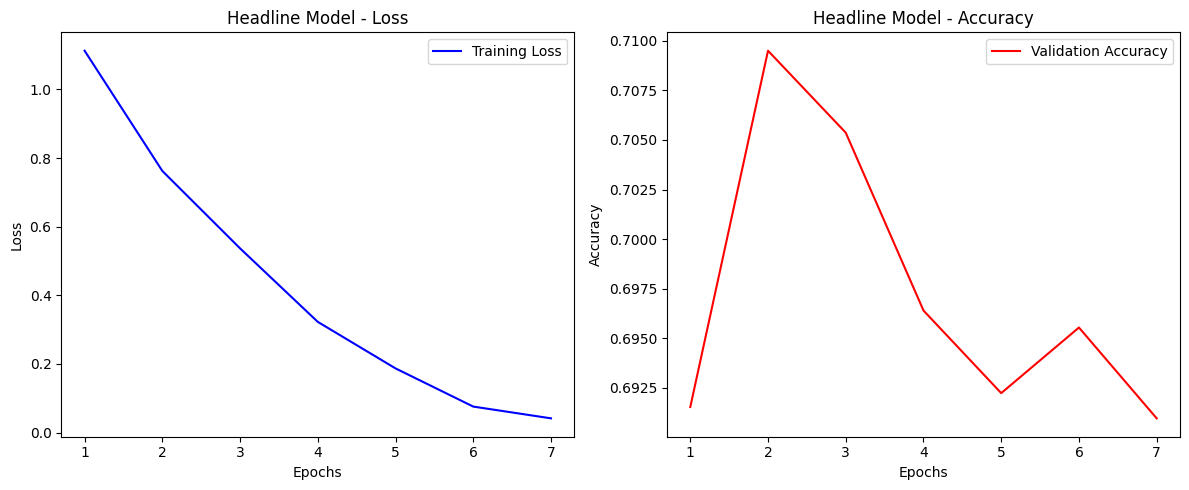


==================== Training Advanced Model on short_description ====================
Pre-tokenizing dataset (this may take a moment)...
Pre-tokenization complete.
Model Parameters: 48.17M
Epoch 1/7 | Loss: 1.3664 | Val Acc: 0.5753
Saved best model to ../Results/second/best_model_description.pt
Epoch 2/7 | Loss: 1.0881 | Val Acc: 0.5970
Saved best model to ../Results/second/best_model_description.pt
Epoch 3/7 | Loss: 0.8693 | Val Acc: 0.5888
Epoch 4/7 | Loss: 0.6080 | Val Acc: 0.5729
Epoch 5/7 | Loss: 0.4296 | Val Acc: 0.5604
Epoch 6/7 | Loss: 0.2871 | Val Acc: 0.5645
Epoch 7/7 | Loss: 0.2408 | Val Acc: 0.5609
Training finished in 18243.83s


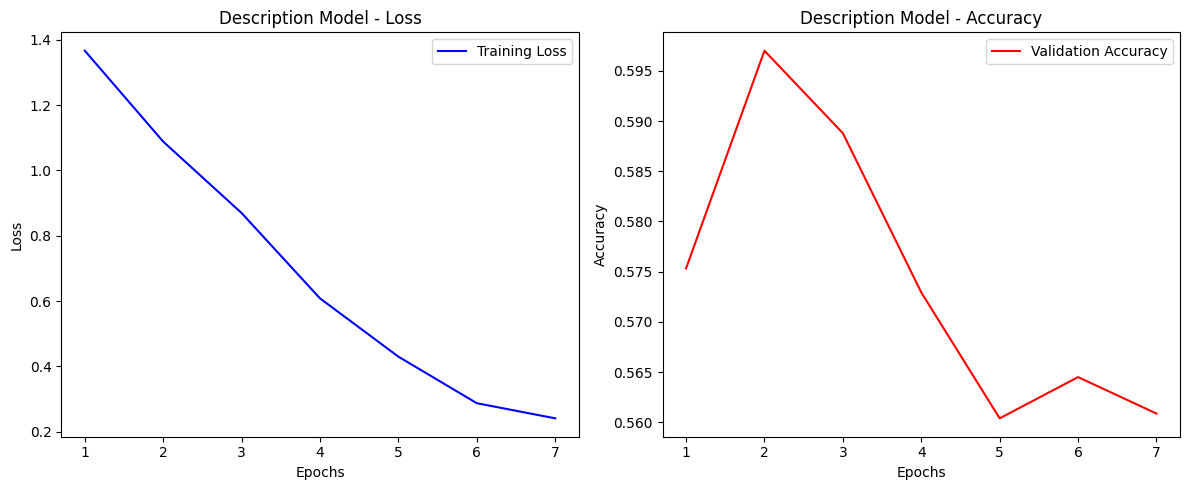


串行训练结束，总耗时: 37399.62s
Headline Best Acc: 0.7095
Description Best Acc: 0.5970


In [5]:
# --- 运行训练 (串行) ---
import time

os.makedirs("../Results/second", exist_ok=True)

print(f"\n{'='*20} 开始串行训练 Advanced 模型 {'='*20}")
start_time_all = time.time()



# 串行训练两个模型

epochs = 7

# 先训练 Headline
acc_h, history_h = run_training(
    text_key="headline", 
    save_name="../Results/second/best_model_headline.pt", 
    epochs=epochs, 
    batch_size=128
)
plot_training_history(history_h, title="Headline Model")

# 再训练 Description
acc_d, history_d = run_training(
    text_key="short_description", 
    save_name="../Results/second/best_model_description.pt", 
    epochs=epochs, 
    batch_size=128
)
plot_training_history(history_d, title="Description Model")

end_time_all = time.time()
print(f"\n串行训练结束，总耗时: {end_time_all - start_time_all:.2f}s")
print(f"Headline Best Acc: {acc_h:.4f}")
print(f"Description Best Acc: {acc_d:.4f}")

## 4. Meta Model (Ensemble)

In [6]:
class MetaClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            nn.ReLU(),                        
            nn.Dropout(0.2),                  
            nn.Linear(hidden_dim, output_dim) 
        )

    def forward(self, x):
        return self.net(x)

def load_advanced_model(path, device):
    checkpoint = torch.load(path, map_location=device)
    vocab = checkpoint["vocab"]
    cfg = checkpoint["config"]
    
    tokenizer = WhitespaceTokenizer(max_vocab_size=len(vocab), max_length=cfg['max_length'])
    tokenizer.token_to_id = vocab
    tokenizer.id_to_token = {v: k for k, v in vocab.items()}
    
    model = AdvancedNewsClassifier(
        vocab_size=len(vocab),
        num_labels=len(checkpoint['label2id']),
        d_model=cfg['d_model'],
        n_head=cfg['n_head'],
        n_layer=cfg['n_layer']
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model, tokenizer, checkpoint['label2id']

def train_meta_model():
    print("\nTraining Meta Model...")
    start_time = time.time()
    # Load Models
    model_h, tok_h, label2id = load_advanced_model("../Results/second/best_model_headline.pt", device)
    model_d, tok_d, _ = load_advanced_model("../Results/second/best_model_description.pt", device)
    
    # Prepare Meta Data
    # Re-split to get meta indices (must match original split)
    full_size = len(records)
    train_size = int(0.7 * full_size)
    val_size = int(0.15 * full_size)
    meta_size = full_size - train_size - val_size
    _, _, meta_subset = random_split(
        range(full_size), [train_size, val_size, meta_size], 
        generator=torch.Generator().manual_seed(42)
    )
    
    X, y = [], []
    with torch.no_grad():
        for idx in meta_subset.indices:
            item = records[idx]
            if item['category'] not in label2id: continue
            target = label2id[item['category']]
            
            # Headline Pred
            ids_h, mask_h = tok_h.encode(item.get('headline', ''))
            logits_h = model_h(torch.tensor([ids_h]).to(device), torch.tensor([mask_h]).to(device))
            probs_h = F.softmax(logits_h, dim=1).cpu().tolist()[0]
            
            # Desc Pred
            ids_d, mask_d = tok_d.encode(item.get('short_description', ''))
            logits_d = model_d(torch.tensor([ids_d]).to(device), torch.tensor([mask_d]).to(device))
            probs_d = F.softmax(logits_d, dim=1).cpu().tolist()[0]
            
            X.append(probs_h + probs_d)
            y.append(target)
            
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.long).to(device)
    
    # Train
    meta_model = MetaClassifier(len(label2id)*2, 64, len(label2id)).to(device)
    optimizer = torch.optim.Adam(meta_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(20):
        optimizer.zero_grad()
        out = meta_model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        if epoch % 5 == 0:
            acc = (torch.argmax(out, dim=1) == y).float().mean()
            print(f"Meta Epoch {epoch}: Loss {loss.item():.4f} Acc {acc:.4f}")
            
    torch.save(meta_model.state_dict(), "../Results/second/best_meta_model.pt")
    print("Meta Model Saved.")
    end_time = time.time()
    print(f"Meta Model Training finished in {end_time - start_time:.2f}s")

train_meta_model()


Training Meta Model...
Meta Epoch 0: Loss 2.1165 Acc 0.0820
Meta Epoch 5: Loss 2.0797 Acc 0.1807
Meta Epoch 10: Loss 2.0444 Acc 0.2923
Meta Epoch 15: Loss 2.0102 Acc 0.3233
Meta Model Saved.
Meta Model Training finished in 360.30s
